# Dengue Modelling

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

## Read & Clean

In [3]:
# read in features, parse the date column to date object

df = pd.read_csv('datasets/dengue_features_train.csv', parse_dates=[3])
target = pd.read_csv('datasets/dengue_labels_train.csv')

# add total cases into df
df['total_cases'] = target['total_cases']

# create new datasets

df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']

## FrontFill to Impute into Missing values

df_sj = df_sj.fillna(method = 'ffill')
df_iq = df_iq.fillna(method = 'ffill')

In [4]:
# set index to the dates
df_sj.set_index('week_start_date', drop = True, inplace = True)
df_iq.set_index('week_start_date', drop = True, inplace = True)

In [5]:
#drop non-numerical values
df_sj.drop(['city', 'year', 'weekofyear'], axis = 1, inplace = True)
df_iq.drop(['city', 'year', 'weekofyear'], axis = 1, inplace = True)


## Modelling

In [368]:
# train test split
sj_train = df_sj.loc[:'2007-04-20']
sj_Xtrain = sj_train.drop('total_cases', axis = 1)
sj_ytrain = sj_train['total_cases']

sj_test = df_sj.loc['2007-04-20':]
sj_Xtest = sj_test.drop('total_cases', axis = 1)
sj_ytest = sj_test['total_cases']


iq_train = df_iq.loc[:'2009-06-20']
iq_Xtrain = iq_train.drop('total_cases', axis = 1)
iq_ytrain = iq_train['total_cases']

iq_test = df_iq.loc['2009-06-20':]
iq_Xtest = iq_test.drop('total_cases', axis = 1)
iq_ytest = iq_test['total_cases']


### Simple Linear Regression
Just to get the ball rolling...

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [137]:
lr = LinearRegression()
lr.fit(sj_Xtrain, sj_ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  


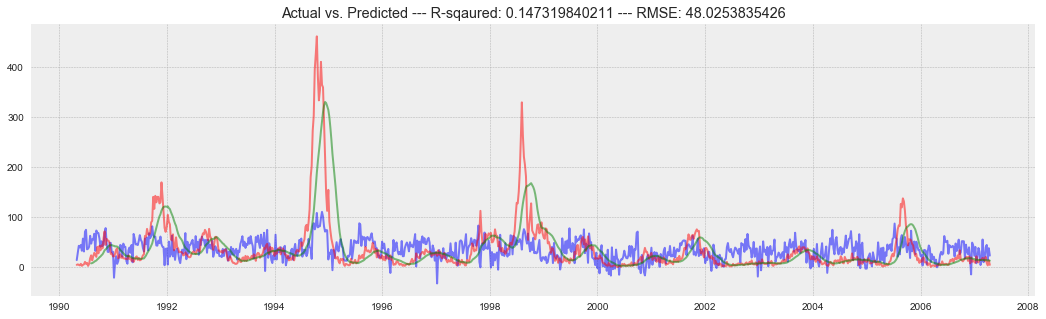

In [398]:
predicts = pd.Series(lr.predict(sj_Xtrain))
predicts.index = sj_ytrain.index
plt.figure(figsize=(18, 5))
plt.plot(predicts.index, predicts, c = 'b', alpha = .5)
plt.plot(sj_ytrain.index, sj_ytrain, c = 'r', alpha = .5)
plt.plot(pd.rolling_mean(sj_ytrain, window = 15), c = 'g', alpha = .5)
plt.title('Actual vs. Predicted --- R-sqaured: ' + 
          str(lr.score(sj_Xtrain, sj_ytrain)) + ' --- RMSE: ' + 
          str(mean_squared_error(predicts, sj_ytrain)**0.5))

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  


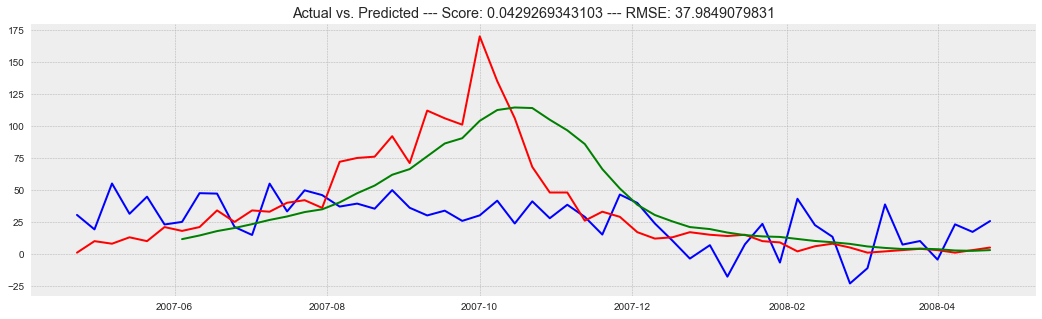

In [401]:
predicts = pd.Series(lr.predict(sj_Xtest))
predicts.index = sj_ytest.index
plt.figure(figsize=(18, 5))
plt.plot(predicts.index, predicts, c = 'b')
plt.plot(sj_ytest.index, sj_ytest, c = 'r')
plt.plot(pd.rolling_mean(sj_ytest, window = 7), c = 'g')
plt.title('Actual vs. Predicted --- Score: ' + 
          str(lr.score(sj_Xtest, sj_ytest)) + ' --- RMSE: ' + 
          str(mean_squared_error(predicts, sj_ytest)**0.5))

## ARIMA Model

Autoregression Integrated Moving Average

Order Parameters (p, d, q):
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

see: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

see: http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html

In [340]:
from statsmodels.tsa.arima_model import ARIMA

In [369]:
sj_ytrain = sj_ytrain.apply(lambda x: float(x))
sj_ytest = sj_ytest.apply(lambda x: float(x))

In [342]:
# create exogenous data to use in ARIMA model

exog_f = np.array(sj_Xtrain[['ndvi_ne']])

# not working...

In [359]:
# fit model
model = ARIMA(sj_ytrain, order=(10,1,0))
model_fit = model.fit()
print model_fit.summary2()

                           Results: ARIMA
Model:              ARIMA            BIC:                 7116.0931 
Dependent Variable: D.total_cases    Log-Likelihood:      -3517.4   
Date:               2017-08-30 12:50 Scale:               1.0000    
No. Observations:   882              Method:              css-mle   
Df Model:           11               Sample:              05-07-1990
Df Residuals:       871                                   04-16-2007
Converged:          1.0000           S.D. of innovations: 13.051    
AIC:                7058.7068        HQIC:                7080.650  
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                -0.0035   0.6087 -0.0057 0.9954 -1.1965  1.1896
ar.L1.D.total_cases   0.1453   0.0336  4.3220 0.0000  0.0794  0.2112
ar.L2.D.total_cases   0.0805   0.0339  2.3784 0.0176  0.0142 

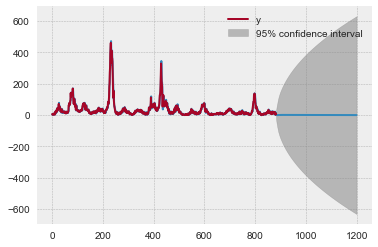

In [345]:
# Plot Current model's predictions against actual on training data
# the trailing blue is predictions, but without including predictions in the model

model_fit.plot_predict(1,1200);


### Make Predictions on sj_test data

In [390]:
# this will create a new model for each loop and make a prediction on the next week's target

sj_ytrain2 = list(sj_ytrain.values)
predictions = []
for t in range(len(sj_ytest)):
    
    # fit model on sj_ytrain every time
    model = ARIMA(sj_ytrain2, order=(3,1,0))
    model_fit = model.fit()
    
    # get next predicted target, add it to predictions list
    output = model_fit.forecast()
    predictions.append(output[0][0])

    # add prediction to sj_ytrain to use in new model
    obs = sj_ytrain2[t]
    sj_ytrain2.append(obs)

Test RMSE: 38.965


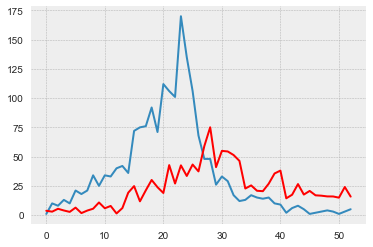

In [391]:
# print error of train vs predictions
error = mean_squared_error(sj_ytest, predictions)**.5
print 'Test RMSE: %.3f' % error

# plot
plt.plot(sj_ytest.values)
plt.plot(predictions, color='red')
plt.show()

## Statsmodel Negative Binomial

see: http://blog.drivendata.org/2016/12/23/dengue-benchmark/

In [323]:
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

In [324]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [325]:
sj_best_model = get_best_model(sj_train, sj_test)
iq_best_model = get_best_model(iq_train, iq_test)

('best alpha = ', 1e-08)
('best score = ', 22.924528301886792)
('best alpha = ', 1e-08)
('best score = ', 5.1132075471698117)


In [336]:
print sj_best_model.summary()
print
print iq_best_model.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  936
Model:                            GLM   Df Residuals:                      931
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                   66.9104329651
Method:                          IRLS   Log-Likelihood:                -20217.
Date:                Tue, 29 Aug 2017   Deviance:                       35977.
Time:                        17:23:49   Pearson chi2:                 6.23e+04
No. Iterations:                     6                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               270.7525    161.515      1.676      0

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


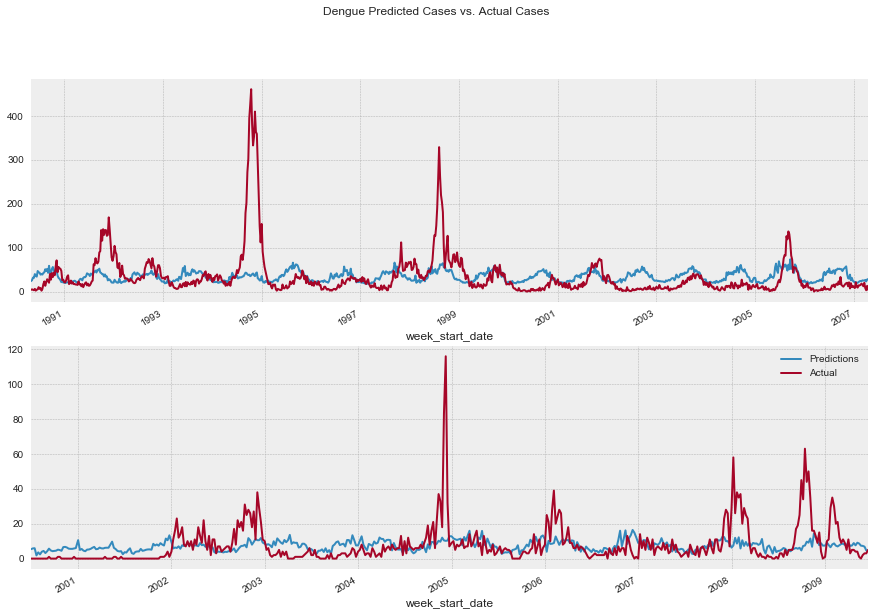

In [332]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Previous weeks as a feature

In [88]:
# create small dataset to test out reformatting

features = ['precipitation_amt_mm', 'station_avg_temp_c', 'total_cases']

sj_small = df_sj[features]
iq_small = df_iq[features]

In [91]:
#create previous 1 week column names
prev1 = ['prev1_' + i for i in features]
prev2 = ['prev2_' + i for i in features]
prev3 = ['prev3_' + i for i in features]
prev4 = ['prev4_' + i for i in features]
prev5 = ['prev5_' + i for i in features]

In [96]:
# Create Dataset with previous features

# create data for 1 week back
for j, k in zip(features, prev1):
    sj_small[k] = [np.nan] + list(sj_small[j][:-1].values)

# create data for 2 weeks back
for j, k in zip(features, prev2):
    sj_small[k] = [np.nan, np.nan] + list(sj_small[j][:-2].values)

# create data for 3 weeks back
for j, k in zip(features, prev3):
    sj_small[k] = [np.nan, np.nan, np.nan] + list(sj_small[j][:-3].values)

# create data for 4 week back
for j, k in zip(features, prev4):
    sj_small[k] = [np.nan, np.nan, np.nan, np.nan] + list(sj_small[j][:-4].values)

# create data for 5 week back
for j, k in zip(features, prev5):
    sj_small[k] = [np.nan, np.nan, np.nan, np.nan, np.nan] + list(sj_small[j][:-5].values)

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [97]:
sj_small.head()

,precipitation_amt_mm,station_avg_temp_c,total_cases,prev1_precipitation_amt_mm,prev1_station_avg_temp_c,prev1_total_cases,prev2_precipitation_amt_mm,prev2_station_avg_temp_c,prev2_total_cases,prev3_precipitation_amt_mm,prev3_station_avg_temp_c,prev3_total_cases,prev4_precipitation_amt_mm,prev4_station_avg_temp_c,prev4_total_cases,prev5_precipitation_amt_mm,prev5_station_avg_temp_c,prev5_total_cases
week_start_date,,,,,,,,,,,,,,,,,,
1990-04-30,12.42,25.442857,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-07,22.82,26.714286,5,12.42,25.442857,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-14,34.54,26.714286,4,22.82,26.714286,5.0,12.42,25.442857,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-21,15.36,27.471429,3,34.54,26.714286,4.0,22.82,26.714286,5.0,12.42,25.442857,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-28,7.52,28.942857,6,15.36,27.471429,3.0,34.54,26.714286,4.0,22.82,26.714286,5.0,12.42,25.442857,4.0,NaN,NaN,NaN
